In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from DSH import MIfile as MI
from DSH import CorrMaps as CM

# Load MI file

```MIfile``` class interacts with MIfiles: read them and write them, and handles metadata from external configuration files.
To load a MIfile together with associated metadata, use:

```python
mi_file = MI.MIfile(MI_filename, Metadata_filename)
```

In [2]:
froot = 'C:\\Users\\steaime\\Documents\\Research\\Codes\\DSH\\DSHpy\\DSH\\test\\'
fname = froot + 'MI0001.dat'
metadata_fname = froot + 'metadata.ini'
mi_file = MI.MIfile(fname, metadata_fname)

```MIfile``` class doesn't load any data from the source MIfile upon initializion.
Data can be retrieved using one of the following functions:

```python
mi_file.Read(zRange=None, cropROI=None, closeAfter=False) #Read multiple images or ROIs from MIfile
mi_file.GetImage(img_idx, cropROI=None) #Read single image or ROI from MIfile
mi_file.GetStack(start_idx=0, imgs_num=-1) #Read contiguous image stack from MIfile
```

Here, ```cropROI``` has to be a 4-element tuple of the form: ```[x, x, w, h]```, 
where ```(x, y)``` is the coordinate of the top-left corner of the ROI (0-based) 
and ```(w, h)``` are width and height, respectively. Setting either ```w``` or ```h``` to ```-1```
indicates that the dimension extends to the image boundary.

Before any reading operation, file handle must be initialized using 

```python
mi_file.OpenForReading()
```

At the end of any reading operation, file handle must be freed using

```python
mi_file.Close()
```

### Test MIfile class

The structure of the MIfile class can be print to output in two ways:

In [3]:
mi_file

<MIfile: 8+2000x1024x1280x1 bytes>

In [4]:
print(mi_file)


|---------------|
| MIfile class: |
|---------------+------------
| Filename      : C:\Users\steaime\Documents\Research\Codes\DSH\DSHpy\DSH\test\MI0001.dat
| Header        : 8bytes
| Shape         : [2000, 1024, 1280]px
| Pixel format  : B (1 bytes/px)
|----------------------------


To get a feeling of what's inside the MIfile let's display one random frame:

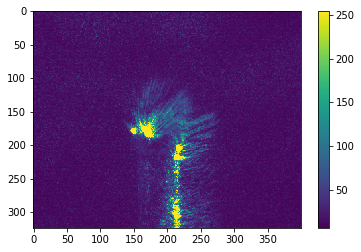

In [5]:
mi_file.OpenForReading()
sample_ROI = mi_file.GetImage(50, cropROI=[400, 700, 400, -1])
plt.imshow(sample_ROI)
plt.colorbar()

# Correlation maps

```MIfile``` class can also be used as an input for ```CorrMaps``` class, which computes correlation maps.
We initialize a ```CorrMaps``` class like this:

```python
corrmap = CM.CorrMaps(MIin, outFolder, lagList, KernelSpecs, imgRange=None, cropROI=None)
```

where:
- ```MIin``` is the input ```MIfile``` class
- ```outFolder``` (```str```) is the output folder where correlation maps will be saved
- ```lagList``` is a list of lagtimes (```int```, **in units of the image range specified in ```imgRange```**). One correlation map will be computer for each lagtime
- ```KernelSpecs``` is a ```dict``` with the kernel for local averaging. Dictionary must have the following entries:
    - ```'type'``` (```str```) is the kernel type. For the moment the only supported type is ```'Gauss'```, a Gaussian kernel, which requires specification of ```'sigma'``` (```float```), the Gaussian standard deviation, and ```'cutoff'```  (```float```), setting where, in units of sigma, the tails of the Gaussian will be trimmed to zero
    - ```'padding'``` (```bool```): if ```True```, the input images will be padded with zeroes such that the output correlation maps will have the same shape as the input images. Otherwise, the correlation maps will have the margins trimmed of an amount equal to the kernel size. This second option makes the analysis potentially faster, but the improvement is only marginal, thus **using padding is recommended**
- ```imgRange``` is a list of 3 ```int``` of the form ```[z_min, z_max, z_step]```. WARNING: this will dictate the range of images analyzed, so ```z_step``` will also renormalize the lagtimes (**This probably needs to be changed**)
- ```cropROI``` contains ROI specs in the same form as the one specified for MIfile class

In [6]:
corrmap = CM.CorrMaps(mi_file, froot, [1], 
                      {'type':'Gauss', 'sigma':2.5, 'cutoff':2, 'padding':True}, 
                      imgRange=[601, 611, 2], cropROI=[640, 0, 640, 512])

Once again, initialization only computes analysis parameters. To actually compute the correlation maps we need to call:

```python
cmap_list = corrmap.Compute(silent=True, return_maps=False)
```

Correlation maps will only returned if argument ```return_maps``` is set to ```True```. However, be aware that this may lead to heavy memory usage, and that no memory check will be done. When ```return_maps==False```, ```None``` will be returned. For testing purposes, we compute correlation maps on a small subset of the MIfile, and we return the output

In [7]:
cmap_list = corrmap.Compute(silent=False, return_maps=True)

Computing correlation maps:
  STEP 1: Preparing memory...
  STEP 2: Loading images...
  STEP 3: Calculating raw correlations...
  STEP 4: Calculating and saving contrast...
  STEP 5: Normalizing and saving correlations...
Procedure completed in 65.5 seconds!


check out one random frame from each correlation map:

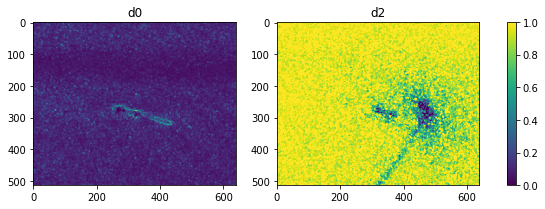

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
tidx = 2
ax1.set_title('d0')
ax1.imshow(cmap_list[0][tidx], vmin=0.0, vmax=1.0)
ax2.set_title('d2')
cbar = ax2.imshow(cmap_list[1][tidx], vmin=0.0, vmax=1.0)
fig.colorbar(cbar, ax=[ax1, ax2], shrink=0.5)

once again, details about the CorrMap class instance can be printed to output by simply doing:

In [9]:
print(corrmap)


|-----------------|
| CorrMaps class: |
|-----------------+------------
| MI Filename     : C:\Users\steaime\Documents\Research\Codes\DSH\DSHpy\DSH\test\MI0001.dat
| output folder   : C:\Users\steaime\Documents\Research\Codes\DSH\DSHpy\DSH\test\
| lag times (01)  : [1]
| image range     : [601, 611, 2]
| crop ROI        : [640, 0, 640, 512]
| Kernel          : Gauss - sigma=2.5, cutoff=2, 
| Kernel size     : 5 PADDING (width=5)
|------------------------------


let's see what happens if we don't use padding:

In [10]:
corrmap_nopad = CM.CorrMaps(mi_file, froot, [1], 
                      {'type':'Gauss', 'sigma':2.5, 'cutoff':2, 'padding':False}, 
                      imgRange=[601, 611, 2], cropROI=[640, 0, 640, 512])
print(corrmap_nopad)
cmap_list_nopad = corrmap_nopad.Compute(silent=False, return_maps=True)


|-----------------|
| CorrMaps class: |
|-----------------+------------
| MI Filename     : C:\Users\steaime\Documents\Research\Codes\DSH\DSHpy\DSH\test\MI0001.dat
| output folder   : C:\Users\steaime\Documents\Research\Codes\DSH\DSHpy\DSH\test\
| lag times (01)  : [1]
| image range     : [601, 611, 2]
| crop ROI        : [640, 0, 640, 512]
| Kernel          : Gauss - sigma=2.5, cutoff=2, 
| Kernel size     : 5 NO PADDING (trimming margin=5)
|------------------------------
Computing correlation maps:
  STEP 1: Preparing memory...
  STEP 2: Loading images...
  STEP 3: Calculating raw correlations...
  STEP 4: Calculating and saving contrast...
  STEP 5: Normalizing and saving correlations...
Procedure completed in 51.3 seconds!


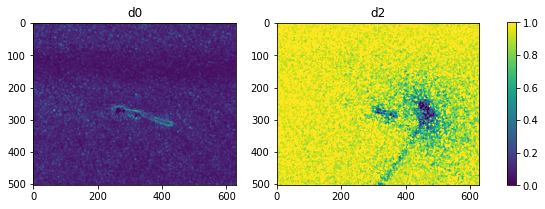

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.set_title('d0')
ax1.imshow(cmap_list_nopad[0][tidx], vmin=0.0, vmax=1.0)
ax2.set_title('d2')
cbar = ax2.imshow(cmap_list_nopad[1][tidx], vmin=0.0, vmax=1.0)
fig.colorbar(cbar, ax=[ax1, ax2], shrink=0.5)

To check that everywhere away from the boundary the two methods are the same we compute the difference:

In [12]:
map_diff = np.subtract(cmap_list[1][tidx][5:-5, 5:-5],cmap_list_nopad[1][tidx])
print(np.max(map_diff))
print(np.min(map_diff))

0.0
0.0
